In [53]:
import numpy as np

import matplotlib as mpl
mpl.use('Qt5Agg')

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.ion()

# for the symbolic manipulation of jacobian
import sympy as sp
from sympy.utilities.lambdify import lambdify

from scipy.optimize import minimize
from scipy.optimize import fsolve

import time

import odrive
import odrive.utils
import odrive.enums

# Design Study

In [43]:
%matplotlib inline

def gaitTrajectoryCycle(on_coords, off_coords, swing_coords, d, T, N):
    """
    return allpts - a list of tuple (x, y) that represents the required 
                    gait trajectory from (xon, yon) to (xoff, yoff) via a
                    straight line and the back to (xon, yon) via
                    (xswing, yswing) along a parabola
                    
    """
    xon, yon = on_coords
    xoff, yoff = off_coords
    xswing, yswing = swing_coords
    
    swing_points = int(N*(1-d))
    print(swing_points)
    swing_pts = []

    # original curve
    coeffs = np.polyfit([xonn, xoff, xswing], [yonn, yoff, yswing], deg=2)


    for i in range(swing_points):
        if xoff > xonn:
            x = xoff - ((np.abs(xoff-xonn)/swing_points)*(i+1))
        else:
            x = xoff + ((np.abs(xoff-xonn)/swing_points)*(i+1))
        
        # use parabola equation to find y coordinate
        y = coeffs[0]*(x**2) + coeffs[1]*x + coeffs[2]
        swing_pts.append((x,y))

    stance_points = int(N*(d))
    stan_pts = []

    linecoeffs = np.polyfit([xonn,xoff],[yonn,yoff],deg=1)
    for i in range(stance_points):
        if xoff > xonn:
            x = xonn + ((np.abs(xoff-xonn)/stance_points)*(i+1))
        else:
            x = xonn - ((np.abs(xoff-xonn)/stance_points)*(i+1))
        
        # use line equation to find y coordinate
        y = linecoeffs[0]*x + linecoeffs[1]
        stan_pts.append((x,y))
    allpts = stan_pts + swing_pts
    return allpts

## Parameters for 1st Case of HW3

50


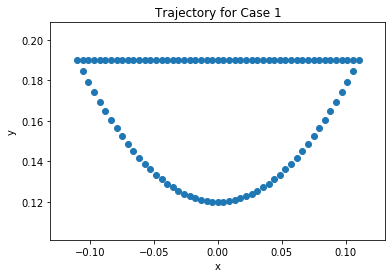

In [3]:
# the gait trajectory has been shifted along
# y-axis since the current trajectory was
# resulting in linkage collisions
yshift = 0.07

xoff = -0.11
yoff = 0.12 + yshift

xonn = 0.11
yonn = 0.12 + yshift

xswing = 0
yswing = 0.05 + yshift

N = 100
d = 0.5
T = 0.25

allpts = gaitTrajectoryCycle((xonn,yonn), (xoff,yoff), 
                             (xswing,yswing), d, T, N)
plt.scatter(*zip(*allpts))
plt.title('Trajectory for Case 1')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Solve for Forward and Inverse Kinematics

In [44]:
# code shared by professor
## Motor constants
K = 0.0285;                 # Nm / A
peak_amp = 30;              # A
peak_torque = K * peak_amp; # Nm
m_motor = 0.2;              # kg
m_assembly = 0.2;           # kg

m_total = 2*m_motor + m_assembly; # kg

gravity = 9.8;              # m/s^2

weight = m_total * gravity  # N

l1 = 0.09;                  # m 
l2 = 0.16;                  # m
w = 0.07;                   # m

# solve jacobian of constraint equation
(thetaL_sym, 
 thetaR_sym, 
 link1_sym, 
 link2_sym, 
 width_sym) = sp.symbols("""thetaL_sym 
                            thetaR_sym 
                            link1_sym 
                            link2_sym 
                            width_sym""", real = True)

def Trnfm(theta, x, y):
    """
    Function to return an arbitrary transformation matrix 
    This is for sympy symbolic calculation
    """
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta), x], 
                      [sp.sin(theta), sp.cos(theta), y],
                      [0, 0, 1]])

def sym_to_np(T):
    return np.array(T).astype(np.float64)



### Solve Forward Kinematics

In [45]:
x_r = width_sym/2 + link1_sym*sp.cos(thetaR_sym)
x_l = -width_sym/2 + link1_sym*sp.cos(thetaL_sym)

y_r = link1_sym*sp.sin(thetaR_sym)
y_l = link1_sym*sp.sin(thetaL_sym)

theta3_sym = sp.atan2(y_r - y_l, x_r - x_l)
L = sp.sqrt((x_l - x_r)**2 + (y_l - y_r)**2)

FK = Trnfm(thetaL_sym, -width_sym/2, 0)@Trnfm(-(thetaL_sym - theta3_sym), link1_sym, 0)@sp.Matrix([L/2, sp.sqrt(link2_sym**2 - (L/2)**2), 1])
FK = FK[:2,:]
FK.simplify()
FK

Matrix([
[                                                                  link1_sym*((sin(thetaL_sym) - sin(thetaR_sym))*sqrt(2*link1_sym**2*cos(thetaL_sym - thetaR_sym) - 2*link1_sym**2 + 2*link1_sym*width_sym*cos(thetaL_sym) - 2*link1_sym*width_sym*cos(thetaR_sym) + 4*link2_sym**2 - width_sym**2)/sqrt(-2*link1_sym**2*cos(thetaL_sym - thetaR_sym) + 2*link1_sym**2 - 2*link1_sym*width_sym*cos(thetaL_sym) + 2*link1_sym*width_sym*cos(thetaR_sym) + width_sym**2) + cos(thetaL_sym) + cos(thetaR_sym))/2],
[link1_sym*(-sin(thetaL_sym) + sin(thetaR_sym))/2 + link1_sym*sin(thetaL_sym) + (-link1_sym*cos(thetaL_sym) + link1_sym*cos(thetaR_sym) + width_sym)*sqrt(2*link1_sym**2*cos(thetaL_sym - thetaR_sym) - 2*link1_sym**2 + 2*link1_sym*width_sym*cos(thetaL_sym) - 2*link1_sym*width_sym*cos(thetaR_sym) + 4*link2_sym**2 - width_sym**2)/(2*sqrt(-2*link1_sym**2*cos(thetaL_sym - thetaR_sym) + 2*link1_sym**2 - 2*link1_sym*width_sym*cos(thetaL_sym) + 2*link1_sym*width_sym*cos(thetaR_sym) + width_sym**2))

In [46]:
def internal_angles(thetaR, thetaL, l1 = l1, l2 = l2, w = w):

    # 
    # system_of_equations = @(x) sum(abs([w + l1*(cos(b1)-cos(a1)) + l2*(cos(x(2))-cos(x(1)));
    #                                    l1*(sin(b1)-sin(a1)) + l2*(sin(x(2))-sin(x(1)))]));
    # 
    # x_guess = [a1, b1 + pi/2];                               
    # % [x,fval,exitflag,output] = fminsearch(system_of_equations, x_guess);
    # [x,fval,exitflag,output] = fmincon(system_of_equations, ...
    #                                    x_guess, ...
    #                                    [], [], [], [], ...
    #                                    [-pi, -pi], [pi, pi]);
    # 
    # a2 = x(1);
    # b2 = x(2);
    # 
    # x = w/2 + l1*cos(b1) + l2*cos(b2);
    # y = l1*sin(b1) + l2*sin(b2);

    def sys(x): 
        return (w + l1*np.cos(thetaR) + l2*np.cos(x[0]) - l1*np.cos(thetaL) - l2*np.cos(x[1]),
                l1*np.sin(thetaR) + l2*np.sin(x[0]) - l1*np.sin(thetaL) - l2*np.sin(x[1]))

    alphaR, alphaL = fsolve(sys, (np.pi/2, np.pi/2))
    
    alphaR = alphaR % (2*np.pi)
    alphaL = alphaL % (2*np.pi)
        
    # Copmute FK for checking
    x = w/2 + l1*np.cos(thetaR) + l2*np.cos(alphaR);
    y = l1*np.sin(thetaR) + l2*np.sin(alphaR);

    return (alphaR, alphaL, x, y)

thetaR = .5
thetaL = np.pi

(alphaR, alphaL, x, y) = internal_angles(thetaR, thetaL)

# Should produce
# alphaL
# Out[17]: 0.8878073988680342

# alphaR
# Out[18]: 2.611036674795031

### Solve Inverse Kinematics

In [47]:
def IK_5_link(x, y, l1 = l1, l2 = l2, w = w):
    
    def leg_wide(var):
        return np.linalg.norm([var[1] - np.pi, var[0]])
    
    def x_constraint_equation(var):
        # should be equal to zero when the 
        return l1**2 - l2**2 + (x - w/2)**2 + y**2 - 2*l1*(y*np.sin(var[0]) + (x - w/2)*np.cos(var[0]))

    def y_constraint_equation(var):
        return l1**2 - l2**2 + (x + w/2)**2 + y**2 - 2*l1*(y*np.sin(var[1]) + (x + w/2)*np.cos(var[1]))

    
    res = minimize(leg_wide, (0.1, 9*np.pi/10), method="SLSQP", constraints= ({"type": "eq", "fun": x_constraint_equation}, 
                                                                               {"type": "eq", "fun": y_constraint_equation}))
    
    return (res, np.linalg.norm([x_constraint_equation(res.x), y_constraint_equation(res.x)]))


# Test, the following theta's correspond to the x-y below
thetaR = .5
thetaL = np.pi
    
x = -0.024021708847354217
y = 0.12411037295149752

res = IK_5_link(x, y)


print("""Compare the FK position (top) and the IK solution (bottom) method: 
          \r\n theta_R = {:.4f} \t theta_L = {:.4f} \r\n theta_R = {:.4f} \t theta_L = {:.4f}""".format(thetaR, thetaL, res[0].x[0], res[0].x[1]))

Compare the FK position (top) and the IK solution (bottom) method: 
          
 theta_R = 0.5000 	 theta_L = 3.1416 
 theta_R = 0.5000 	 theta_L = 3.1416


## Joint Angle vs Time plot

In [ ]:
timeThetaL=[]
timeThetaR=[]

interval=T/N

for i, pt in enumerate(allpts):
    x,y = pt
    res = IK_5_link(x,y)
    thetaR = res[0].x[0]
    thetaL = res[0].x[1]
    time_sec = (i+1)*interval
    timeThetaL.append((time_sec, thetaL))
    timeThetaR.append((time_sec, thetaR))

fig, axs = plt.subplots(2, figsize=(10,10))
axs[0].scatter(*zip(*timeThetaL))
axs[0].set_title('Case 1 - joint angle thetaL vs time')
axs[0].set_xlabel('time')
axs[0].set_ylabel('theta L')

axs[1].scatter(*zip(*timeThetaR))
axs[1].set_title('Case 1 - joint angle thetaR vs time')
axs[1].set_xlabel('time')
axs[1].set_ylabel('theta R')
fig.tight_layout()
plt.show()

## Parameters for 2nd Case of HW3

In [ ]:
# the gait trajectory has been shifted along
# y-axis since the current trajectory was
# resulting in linkage collisions
yshift = 0.05

xoff = -0.08
yoff = 0.10 + yshift

xonn = 0.11
yonn = 0.14 + yshift

xswing = 0.05
yswing = 0.05 + yshift

N = 100
d = 0.75
T = 0.5

allpts = gaitTrajectoryCycle((xonn,yonn), (xoff,yoff), 
                             (xswing,yswing), d, T, N)
plt.scatter(*zip(*allpts))
plt.title('Trajectory for Case 2')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Joint Angle vs Time plot

In [ ]:
timeThetaL=[]
timeThetaR=[]
timeAngles=[]

interval=T/N

for i, pt in enumerate(allpts):
    x,y = pt
    res = IK_5_link(x,y)
    thetaR = res[0].x[0]
    thetaL = res[0].x[1]
    time_sec = (i+1)*interval
    timeThetaL.append((time_sec, thetaL))
    timeThetaR.append((time_sec, thetaR))
    timeAngles.append((time_sec, thetaL, thetaR))

fig, axs = plt.subplots(2, figsize=(10,10))
axs[0].scatter(*zip(*timeThetaL))
axs[0].set_title('Case 2 - joint angle thetaL vs time')
axs[0].set_xlabel('time')
axs[0].set_ylabel('theta L')

axs[1].scatter(*zip(*timeThetaR))
axs[1].set_title('Case 2 - joint angle thetaR vs time')
axs[1].set_xlabel('time')
axs[1].set_ylabel('theta R')
fig.tight_layout()
plt.show()

## Parameters for 3rd Case of HW3

100


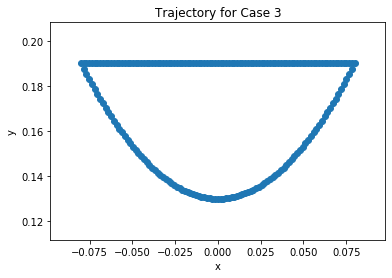

In [48]:
# the gait trajectory has been shifted along
# y-axis since the current trajectory was
# resulting in linkage collisions
yshift = 0.09

xoff = -0.08
yoff = 0.10 + yshift

xonn = 0.08
yonn = 0.10 + yshift

xswing = 0
yswing = 0.04 + yshift

N = 200
d = 0.5
T = 1.5

allpts = gaitTrajectoryCycle((xonn,yonn), (xoff,yoff), 
                             (xswing,yswing), d, T, N)
plt.scatter(*zip(*allpts))
plt.title('Trajectory for Case 3')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Joint Angle vs Time plot

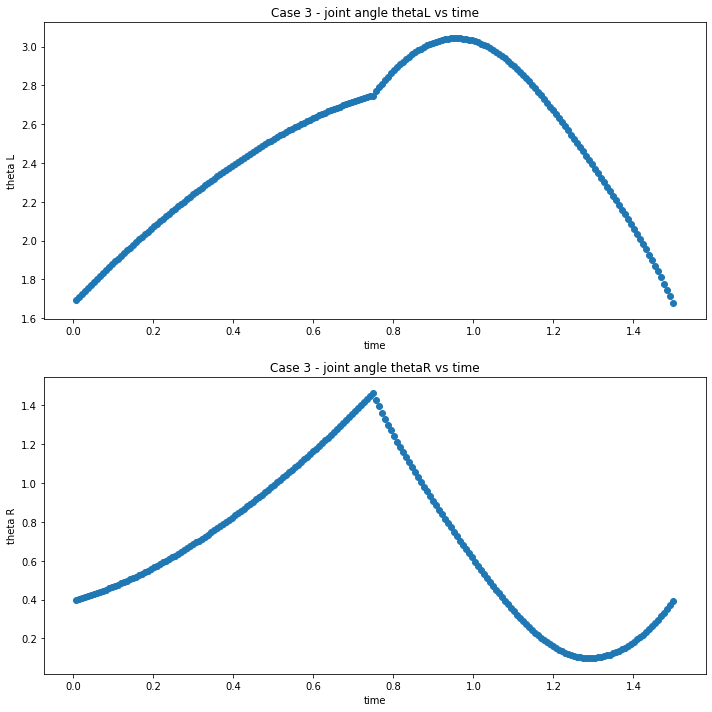

In [49]:
timeThetaL=[]
timeThetaR=[]
timeAngles=[]

interval=T/N

for i, pt in enumerate(allpts):
    x,y = pt
    res = IK_5_link(x,y)
    thetaR = res[0].x[0]
    thetaL = res[0].x[1]
    time_sec = (i+1)*interval
    timeThetaL.append((time_sec, thetaL))
    timeThetaR.append((time_sec, thetaR))
    timeAngles.append((time_sec, thetaL, thetaR))

fig, axs = plt.subplots(2, figsize=(10,10))
axs[0].scatter(*zip(*timeThetaL))
axs[0].set_title('Case 3 - joint angle thetaL vs time')
axs[0].set_xlabel('time')
axs[0].set_ylabel('theta L')

axs[1].scatter(*zip(*timeThetaR))
axs[1].set_title('Case 3 - joint angle thetaR vs time')
axs[1].set_xlabel('time')
axs[1].set_ylabel('theta R')
fig.tight_layout()
plt.show()

# Hands on Study

## 1
Video can be viewed [here](https://drive.google.com/open?id=1zroBBbNkSy9SrHy99chM4LuCHi5hkWOG)    
Or at the link: https://drive.google.com/open?id=1zroBBbNkSy9SrHy99chM4LuCHi5hkWOG

## 2

Code to actually move the foot along a given trajectory

In [51]:
# 306639533235 left motor config
# 3081396C3235 right motor config (kandoi, chinmay setup)
odrv0 = odrive.find_any(serial_number = '3081396C3235', timeout = 20)
if odrv0 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv0.serial_number))
    
    odrv0.axis0.motor.config.pre_calibrated = True
    odrv0.axis1.motor.config.pre_calibrated = True
    
    m0 = odrv0.axis0.motor.is_calibrated
    m1 = odrv0.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1)) 

Connected!
Odrive serial 53331572306485
Motor 0 calibrated: False
Motor 1 calibrated: True


In [12]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

time.sleep(15)

print('Motor 0 calibration result: {} \r\n'.format(odrv0.axis0.motor.is_calibrated), 
      'Motor 1 calibration result: {}'.format(odrv0.axis1.motor.is_calibrated))

	 Motor 0 calibration result: True 
 	 Motor 1 calibration result: True


## Perturbation Recovery Gait

In [52]:
def GateCentre(entireTraj):
    xCoordList = np.array([coords[0] for coords in entireTraj])
    yCoordList = np.array([coords[1] for coords in entireTraj])
    yCentre = np.mean(yCoordList) # y of new center
    xCentre = np.mean(xCoordList) # x of new center
    newOrigin = np.array([xCentre, yCentre])
    return newOrigin

def getNewCoordinates(gaitOrigin, x, y):
    # get point from leg coordinate system
    # change it's values to new coordinate system
    newX = x - gaitOrigin[0]
    newY = y - gaitOrigin[1]
    newCoordinates = np.array([newX, newY])
    return newCoordinates

def getWorldCoord(gaitOrigin, x, y):
    worldX = x + gaitOrigin[0]
    worldY = y + gaitOrigin[1]
    worldCoordinates = np.array([worldX, worldY])
    return worldCoordinates

def getNewPolarCoordinates(gaitCartesianCoord):
    radial_len = np.sqrt(gaitCartesianCoord[0]**2 + gaitCartesianCoord[1]**2)
    beta = np.arctan2(gaitCartesianCoord[1], gaitCartesianCoord[0])
    polar = np.array([radial_len, beta])
    return polar

def closestPointInTrajectory(currPos, targetTraj, length): # should take actual position and command list(x,y) coordinates
    # in nutshell I am finding nearest point in the trajectory
    error = []
    for idx, val in enumerate(targetTraj):# enter command list(x,y)
        coords = np.array([val[0], val[1]])
        err = np.linalg.norm(currPos-coords)
        error.append(err)
    minerr_idx = np.argmin(error)
#     print((minerr_idx + 1) % length)
    return targetTraj[(minerr_idx + 1) % length]

def closestPolarPointInTrajectory(currPolarPos, targetPolarTraj, length, startidx): # should take actual position and command list(x,y) coordinates
    # in nutshell I am finding nearest point in the trajectory
    traj_np = np.array(targetPolarTraj).reshape((-1,2))
    error = np.square(traj_np[:,1]-currPolarPos[1])
    minerr_idx = np.argmin(error)
    # print('min at idx', startidx + minerr_idx)
    return targetPolarTraj[minerr_idx]

def idxOfClosestPolarPointInTraj(currPolarPos, targetPolarTraj, margin, length):
    # find index of closest point in trajectory
    traj_np = np.array(targetPolarTraj).reshape((-1,2))
    error = np.square(traj_np[:,1]-currPolarPos[1])
    minerr_idx = np.argmin(error)
    return (minerr_idx + margin) % length

In [36]:
zero_L = odrv0.axis0.encoder.pos_estimate
zero_R = odrv0.axis1.encoder.pos_estimate
print('zero_L',zero_L)
print('zero_R',zero_R)

zero_L -1178.7664794921875
zero_R 321.234130859375


In [37]:
odrv0.axis0.controller.error=0
odrv0.axis0.motor.error=0
odrv0.axis0.encoder.error=0
odrv0.axis0.error=0

odrv0.axis1.controller.error=0
odrv0.axis1.motor.error=0
odrv0.axis1.encoder.error=0
odrv0.axis1.error=0

# current limit
curr_limit = 25 #A
odrv0.axis0.motor.config.current_lim = curr_limit
odrv0.axis1.motor.config.current_lim = curr_limit

In [38]:
# set errors to 0
odrv0.axis0.controller.error=0
odrv0.axis0.motor.error=0
odrv0.axis0.encoder.error=0
odrv0.axis0.error=0

odrv0.axis1.controller.error=0
odrv0.axis1.motor.error=0
odrv0.axis1.encoder.error=0
odrv0.axis1.error=0

odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL

motor_cpr = (odrv0.axis0.encoder.config.cpr, 
             odrv0.axis1.encoder.config.cpr)

def encoderCountAtAngleL(angle, zerocount, motor_cpr):
    #thetaL = 2*np.pi*(1/2-(odrv0.axis0.encoder.pos_estimate - zero_L)/motor_cpr[0])
    count = zerocount + motor_cpr*(1/2-angle/(2*np.pi))
    return count

def encoderCountAtAngleR(angle, zerocount, motor_cpr):
    #thetaR = -2*np.pi*(odrv0.axis1.encoder.pos_estimate - zero_R)/motor_cpr[1]
    count = zerocount - (motor_cpr*angle)/(2*np.pi)
    return count

def getAngleL(count, zerocount, motor_cpr):
    thetaL = 2*np.pi*(1/2-(count - zerocount)/motor_cpr)
    return thetaL

def getAngleR(count, zerocount, motor_cpr):
    thetaR = -2*np.pi*(count - zerocount)/motor_cpr
    return thetaR

t, thetaL, thetaR = timeAngles[0]
print(thetaL, thetaR)
M = FK.subs([(thetaL_sym, thetaL),(thetaR_sym, thetaR),(link1_sym, l1),(link2_sym, l2),(width_sym, w)])
x, y = sym_to_np(M).reshape((1,2))[0]
print(x, y)

countL = encoderCountAtAngleL(thetaL, zero_L, motor_cpr[0])
print('countL', countL)
countR = encoderCountAtAngleR(thetaR, zero_R, motor_cpr[1])
print('countR', countR)
odrv0.axis0.controller.set_pos_setpoint(countL,0,0)
odrv0.axis1.controller.set_pos_setpoint(countR,0,0)

assert countL-zero_L < 2500, 'diff in count for M0 is too high'
assert countR-zero_R > -2500, 'diff in count for M1 is too high'


zero_L -1178.7664794921875
zero_R 321.234130859375
1.6928842762091043 0.39895058174251957
0.07839999998558911 0.18999999999632552
countL 710.0555824549019
countR -198.91655797997112


In [39]:
actualAnglesL = []
actualAnglesR = []
timeActualPos = []

gaitOrigin = GateCentre(allpts)
allpts_gait = []
allpts_gait_polar = []

zero_pi_add_val = 0
zero_min_pi_add_val = 2*np.pi
prev = 0
for loop_idx in np.arange(0, 10):
    for idx, val in enumerate(allpts):
        x,y = val
        x_gait, y_gait = getNewCoordinates(gaitOrigin, x, y)
        polar_gait = getNewPolarCoordinates(np.array([x_gait, y_gait]))
#         polar_gait[1] += 2*np.pi*loop_idx
        if polar_gait[1] > 0 and polar_gait[1] < np.pi:
            if prev == 1:
                zero_min_pi_add_val += 2*np.pi
            prev = 0
            polar_gait[1] += zero_pi_add_val
        else:
            if prev == 0:
                zero_pi_add_val += 2*np.pi
            prev = 1
            polar_gait[1] += zero_min_pi_add_val
        
        allpts_gait.append((x_gait, y_gait))
        allpts_gait_polar.append((polar_gait[0], polar_gait[1]))

print(allpts_gait_polar[:10], '\n')
print(allpts_gait_polar[100:120], '\n')
print(allpts_gait_polar[180:210], '\n')


print(allpts_gait_polar[210:220], '\n')
print(allpts_gait_polar[300:320], '\n')
print(allpts_gait_polar[380:410], '\n')


[(0.08091032075081647, 0.24975083776449566), (0.07936094760018937, 0.25473391451554234), (0.07781362351156772, 0.25991530121248113), (0.0762684731983013, 0.2653067807208634), (0.07472563150619742, 0.2709210621880822), (0.0731852444417589, 0.2767718709461349), (0.07164747032519712, 0.2828740486814025), (0.0701124810857525, 0.2892436651966023), (0.06858046371963378, 0.29589814327528624), (0.06705162193414864, 0.3028563983707986)] 

[(0.08035605069937173, 2.9204967507993436), (0.07830802280737267, 2.9450235522513513), (0.07631778427077138, 2.970231404179849), (0.0743855599158869, 2.996132754495587), (0.07251155496884618, 3.022738819769285), (0.07069595069026231, 3.05005937284885), (0.06893889958506735, 3.0781025194882865), (0.0672405201942995, 3.1068744666792467), (0.0656008914878449, 3.1363792861878785), (0.0640200468915792, 3.166618677665269), (0.06249796799896777, 3.197591736588281), (0.06103457803573316, 3.2292947331567667), (0.05962973516627422, 3.261720909070173), (0.058283225751497

In [191]:
actualcount_L = odrv0.axis0.encoder.pos_estimate
actualThetaL = getAngleL(actualcount_L, zero_L, motor_cpr[0])
actualcount_R = odrv0.axis1.encoder.pos_estimate
actualThetaR = getAngleR(actualcount_R, zero_R, motor_cpr[1])

# 2. find closest pt on the trajectory and its thetaL and thetaR
M = frwd_kinmtcs_lambda(actualThetaR, actualThetaL)
actualX, actualY = sym_to_np(M).reshape((1,2))[0]

print(actualX, actualY)

-0.21219016698390175 0.03181946470648556


In [24]:
# -0.21219016698390175 to 0.20728376320328756
start_x = -0.220*1000 # -220
end_x = 0.220*1000 # 220
possible_x = np.arange(start_x, end_x, 1) # in mm

# 0.0732437783436377 to 0.24719020748058496
start_y = 0.070*1000 # 70
end_y = 0.250*1000 # 250
possible_y = np.arange(start_y, end_y, 1) # in mm

# make cache
ik_map = np.zeros((possible_x.shape[0], possible_y.shape[0], 2))

def get_x_idx(x, start_x):
    return int(x - int(start_x))

def get_y_idx(y, start_y):
    return int(y - int(start_y))

"""
for x in possible_x:
    for y in possible_y:
        print(x, y)
        x_idx = get_x_idx(x, start_x)
        y_idx = get_y_idx(y, start_y)
        res = IK_5_link(x/1000, y/1000)
        thetaR = res[0].x[0]
        thetaL = res[0].x[1]
        ik_map[x_idx, y_idx, 0] = thetaL
        ik_map[x_idx, y_idx, 1] = thetaR
"""
# np.save('ik_map_2.npy', ik_map)
ik_map = np.load('ik_map.npy')
def get_ik(world_x, world_y):
    x_idx = get_x_idx(world_x*1000, start_x)
    y_idx = get_y_idx(world_y*1000, start_y)
    return ik_map[x_idx,y_idx,:]

In [19]:
ik_map = np.load('ik_map.npy')

In [25]:
get_ik(0.1211999, 0.17000099999)

array([1.36294095, 0.11175418])

In [40]:
last_actual_idx = 0

frwd_kinmtcs = FK.subs([(link1_sym, l1),(link2_sym, l2),(width_sym, w)]).evalf()
frwd_kinmtcs_lambda = lambdify((thetaR_sym, thetaL_sym), frwd_kinmtcs)

for idx, val in enumerate(allpts_gait_polar):
    loop_start = time.process_time()
    
    # 1. find actual thetaL and thetaR
    actualcount_L = odrv0.axis0.encoder.pos_estimate
    actualThetaL = getAngleL(actualcount_L,zero_L, motor_cpr[0])
    actualcount_R = odrv0.axis1.encoder.pos_estimate
    actualThetaR = getAngleR(actualcount_R,zero_R, motor_cpr[1])

    # 2. find closest pt on the trajectory and its thetaL and thetaR
    M = frwd_kinmtcs_lambda(actualThetaR, actualThetaL)
    actualX, actualY = sym_to_np(M).reshape((1,2))[0]
#     print('\nactualX and actualY are', actualX, actualY)
    actualX_gait, actualY_gait = getNewCoordinates(gaitOrigin, actualX, actualY)
    
    timetaken = time.process_time()-loop_start
    print('got new coords in {} sec'.format(timetaken))

    no_pertub_idx = idx

    polar_gait = getNewPolarCoordinates(np.array([actualX_gait, actualY_gait]))
#     print('polar_gait', polar_gait)

    actual_idx = idxOfClosestPolarPointInTraj(polar_gait, allpts_gait_polar, margin=2, length=N)
    
    timetaken2 = time.process_time()-timetaken
    print('got id of closest polar pt in {} sec'.format(timetaken2))
    
    curr_setpt = odrv0.axis0.motor.current_control.Iq_setpoint
    if actual_idx <= last_actual_idx and np.abs(curr_setpt) < 10:
#         print('no change in actual_idx so bumped it to last_actual_idx + 1')
        actual_idx = last_actual_idx + 1
    elif actual_idx <= last_actual_idx:
#         print('seems like a perturbation, so will keep it at last_actual_idx')
        actual_idx = last_actual_idx
        
#     print('trying to do current:', odrv0.axis0.motor.current_control.Iq_setpoint)

#     print('actual_idx', actual_idx)
    last_actual_idx = actual_idx # update last actual idx
    startidx = actual_idx+1
    endidx = actual_idx+16
    frwd_pts_gait_polar = allpts_gait_polar[startidx:endidx]
    nextPtRadial_gait, nextPtTheta_gait = closestPolarPointInTrajectory(
                                            polar_gait,
                                            frwd_pts_gait_polar,
                                            len(frwd_pts_gait_polar),
                                            startidx)
    nextPtX_gait, nextPtY_gait = nextPtRadial_gait*np.cos(nextPtTheta_gait), \
                                    nextPtRadial_gait*np.sin(nextPtTheta_gait)
    nextPtX_world, nextPtY_world = getWorldCoord(gaitOrigin, nextPtX_gait, nextPtY_gait)
    
    timetaken3 = time.process_time()-timetaken2
    print('got id of closest polar pt in {} sec'.format(timetaken3))
    
    thetaL, thetaR = get_ik(nextPtX_world, nextPtY_world)
#     res = IK_5_link(nextPtX_world, nextPtY_world)
#     thetaR = res[0].x[0]
#     thetaL = res[0].x[1]

    # 3. command motors to go to the closest pt
    countL = encoderCountAtAngleL(thetaL, zero_L, motor_cpr[0])
    countR = encoderCountAtAngleR(thetaR, zero_R, motor_cpr[1])
    odrv0.axis0.controller.set_pos_setpoint(countL,0,0)
    odrv0.axis1.controller.set_pos_setpoint(countR,0,0)

    actualAnglesL.append(((idx+1)*t, actualThetaL))
    actualAnglesR.append(((idx+1)*t, actualThetaR))

time.sleep(3)
odrv0.axis0.controller.set_pos_setpoint(zero_L,0,0)
odrv0.axis1.controller.set_pos_setpoint(zero_R,0,0)
time.sleep(3)
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

ValueError: attempt to get argmin of an empty sequence

In [34]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

In [ ]:
def findCoordOfEndPt(thetaL, thetaR):
    M = FK.subs([(thetaL_sym, thetaL),(thetaR_sym, thetaR),(link1_sym, l1),(link2_sym, l2),(width_sym, w)])
    x, y = sym_to_np(M).reshape((1,2))[0]
    return x, y

for idx, val in enumerate(actualAnglesL):
    thetaL = actualAnglesL[idx][1]
    thetaR = actualAnglesR[idx][1]
    actualX, actualY = findCoordOfEndPt(thetaL, thetaR)
    timeActualPos.append((actualX, actualY))

In [ ]:
figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(*zip(*timeActualPos), label='actual foot position')
plt.scatter(*zip(*allpts), label='target foot position')
plt.scatter(xonn, yonn)
# point1 = [timeActualPos]
# for idx in np.arange():
#     point1 = [1, 2]
#     point2 = [3, 4]
#     x_values = [point1[0], point2[0]]
#     y_values = [point1[1], point2[1]]

#     plt.plot(x_values, y_values)

plt.title('actual & target foot position')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Code to plot actual  and commanded motor position vs time

In [ ]:
plt.scatter(*zip(*actualAnglesL), label='actual motor position')
plt.scatter(*zip(*timeThetaL), label='commanded motor position')
plt.title('Case 1 - actual & commanded motor position (thetaL) vs time')
plt.xlabel('time')
plt.ylabel('theta L')
plt.legend()
plt.show()